In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sin
from math import pi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
from keras.optimizers import RMSprop

In [2]:
warnings.simplefilter('ignore')

Считываем данные и посмотрим на них

In [3]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

In [4]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [5]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [6]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [7]:
aggregation = {
    'ACTUAL': 'sum',
    'PROMO': 'max',
    'YEAR': 'max',
    'MONTH': 'max',
    'DAY': 'max'
}

In [8]:
def sin_day(val):
    return sin(val*(2*pi)/31)

In [9]:
def sin_month(val):
    return sin(val*(2*pi)/12)

Выберем определенный opstudy (например 51) и будем с ним работать

In [10]:
opst_51 = data[data['OPSTUDY']==51].copy()

Удалим в новом датасете столбцы 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', так как мы уже определились с opstudy; колонку 'SEG' удалим, так как она не очень информативна; также удалим все остальные описательные характеристики продуктов 

In [11]:
opst_51.drop(['PLN_LABEL', 'PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', 'SEG'], axis=1, inplace=True)

Преобразуем наши данные в необходимые типы, а также приведем колонку 'WEEK' в нужный строковый тип при помощи функции date_divide, чтобы потом привести в дату

In [12]:
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: str(x))
opst_51['PLN'] = opst_51['PLN'].apply(lambda x: str(x))
opst_51['ACTUAL'] = opst_51['ACTUAL'].apply(lambda x: float(x))
opst_51['PROMO'] = opst_51['PROMO'].apply(lambda x: str(x))
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: date_divide(x))

Приводим 'WEEK' в дату и создаем еще три колонки: год, месяц и день (неделю)

In [13]:
opst_51['WEEK'] = pd.to_datetime(opst_51['WEEK'])
opst_51['YEAR'] = [d.year for d in opst_51['WEEK']]
opst_51['MONTH'] = [d.month for d in opst_51['WEEK']]
opst_51['DAY'] = [d.day for d in opst_51['WEEK']]

Создаем словарь и заменяем колонку 'PROMO' на числовые значения; кроме того в колонке часто встречаются пропуски, это связано с тем, что в наших данных встречаются для одних и тех же pln повторяющиеся недели. В таких случаях одно из значений будет 0 или 1 а другие nan. Заменим пока все nan на 0, а затем при агрегации будем брать максимум (если хотя бы в одной недели была 1, то значит 'PROMO' принимает значение 1)

In [14]:
promo_dict = {'N':0, 'Y':1}
opst_51['PROMO'] = opst_51['PROMO'].replace(promo_dict)
opst_51['PROMO'] = opst_51['PROMO'].replace({'nan':0})

Проведем агрегацию данных по дате и pln

In [15]:
opst_51 = opst_51.groupby(['WEEK', 'PLN'], as_index=False).agg(aggregation)

Возьмем первый попавшийся pln и сделаем отдельно для него прогноз

In [16]:
first_pln = opst_51[opst_51['PLN']=='40000131497'].copy()

In [17]:
first_pln.drop('PLN', axis=1, inplace=True)

Введем новый признак - среднее значение продаж по каждому месяцу

In [18]:
first_pln['YEAR_MONTH'] = [str(d.year) + '/' + str(d.month) for d in first_pln['WEEK']]
year_month = np.unique(first_pln['YEAR_MONTH'].values)
ym_mean = np.array([first_pln[first_pln['YEAR_MONTH']==d]['ACTUAL'].mean() for d in year_month])
mean_dict = dict(zip(year_month, ym_mean))
first_pln['MEAN_PER_MONTH'] = first_pln['YEAR_MONTH'].replace(mean_dict)

Значения данных в зависимости от признака сильно разнятся, поэтому нормализируем наши данные о продажах и среднее по месяцам

In [19]:
scaler = MinMaxScaler()
scaler.fit(np.array(first_pln['ACTUAL']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['ACTUAL']).reshape(-1, 1))
first_pln['ACTUAL'] = norm_act.ravel()

In [20]:
scaler.fit(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
first_pln['MEAN_PER_MONTH'] = norm_act.ravel()

Приведем также признаки месяц и день к синусу и косинусу, располагая дни\месяца на тригонометрической окружности; признак 'YEAR' удалим

In [21]:
first_pln.reset_index(inplace=True)
first_pln.set_index('WEEK', inplace=True)
first_pln.drop(['YEAR_MONTH', 'YEAR'], axis=1, inplace=True)
first_pln['MONTH'] = first_pln['MONTH'].apply(lambda m: sin_month(m))
first_pln['DAY'] = first_pln['DAY'].apply(lambda d: sin_day(d))
first_pln.reset_index('WEEK', inplace=True)
first_pln.drop('index', axis=1, inplace=True)

Взглянем на получившиеся данные

In [22]:
first_pln.head()

,WEEK,ACTUAL,PROMO,MONTH,DAY,MEAN_PER_MONTH
0,2015-02-08,0.046961,0,0.866025,0.998717,0.037634
1,2015-02-15,0.039595,0,0.866025,0.101168,0.037634
2,2015-02-22,0.039595,0,0.866025,-0.968077,0.037634
3,2015-03-01,0.033149,0,1.000000,0.201299,0.083073
4,2015-03-08,0.067219,0,1.000000,0.998717,0.083073


Построим графики продаж и среднего за месяц

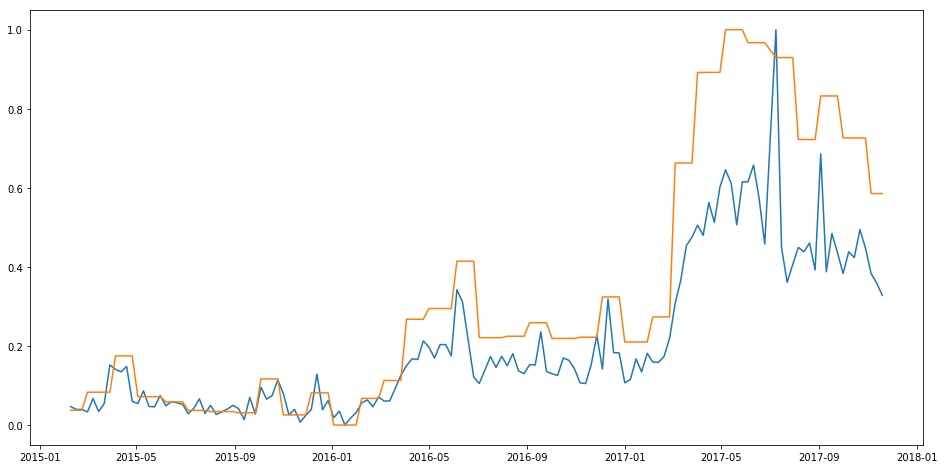

In [23]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['ACTUAL'])
plt.plot(first_pln['WEEK'], first_pln['MEAN_PER_MONTH'])
plt.show()

Графики дней и месяцев

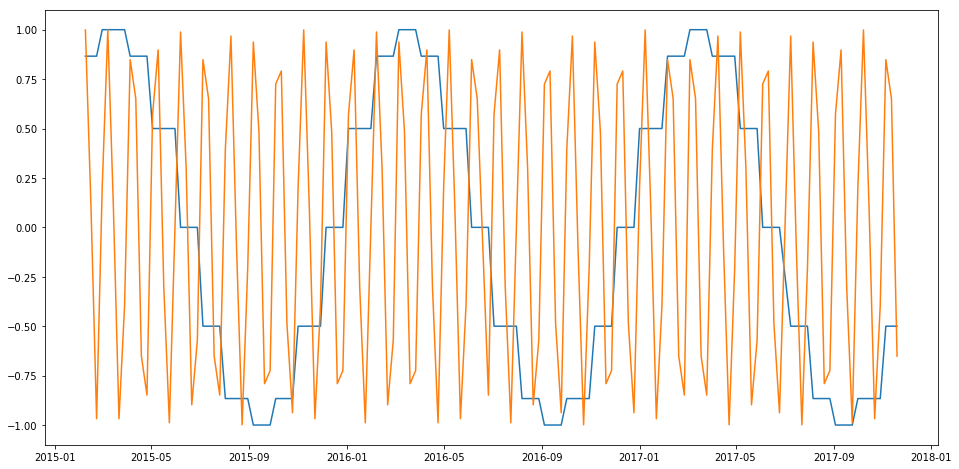

In [24]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH'])
plt.plot(first_pln['WEEK'], first_pln['DAY'])
plt.show()

Поставим целевой признак в конец датасета

In [25]:
act = first_pln['ACTUAL']
first_pln.drop('ACTUAL', axis=1, inplace = True)
first_pln.insert(5, 'ACTUAL', act)

In [26]:
first_pln['WEEK'] = first_pln['WEEK'].apply(lambda x: str(x))

In [27]:
first_pln.set_index('WEEK', inplace=True)

In [36]:
first_pln.head()

,PROMO,MONTH,DAY,MEAN_PER_MONTH,ACTUAL
WEEK,,,,,
2015-02-08 00:00:00,0,0.866025,0.998717,0.037634,0.046961
2015-02-15 00:00:00,0,0.866025,0.101168,0.037634,0.039595
2015-02-22 00:00:00,0,0.866025,-0.968077,0.037634,0.039595
2015-03-01 00:00:00,0,1.000000,0.201299,0.083073,0.033149
2015-03-08 00:00:00,0,1.000000,0.998717,0.083073,0.067219


Преобразуем еще немного наши данные, а именно измених их размерности (для того, чтобы скормить их нашей сети необходимо привести их к трехмерным тензорам); помимо этого разделим наш набор на тестовую и обучающую выборки

In [37]:
lstm_data = first_pln.values

In [38]:
train = lstm_data[:100, :]
test = lstm_data[100:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 1, 4) (100,) (44, 1, 4) (44,)


Входным слоем нашей сети будет lstm слой, оптимизатор - RMSprop, для оценки ошибки возьмем среднюю абсолютную ошибку, в качестве валидационных данных возьмем тестовую выборку

In [39]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=RMSprop())
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 100 samples, validate on 44 samples
Epoch 1/50
 - 1s - loss: 0.1055 - val_loss: 0.4215
Epoch 2/50
 - 0s - loss: 0.0807 - val_loss: 0.3993
Epoch 3/50
 - 0s - loss: 0.0663 - val_loss: 0.3820
Epoch 4/50
 - 0s - loss: 0.0590 - val_loss: 0.3688
Epoch 5/50
 - 0s - loss: 0.0563 - val_loss: 0.3584
Epoch 6/50
 - 0s - loss: 0.0548 - val_loss: 0.3489
Epoch 7/50
 - 0s - loss: 0.0536 - val_loss: 0.3400
Epoch 8/50
 - 0s - loss: 0.0528 - val_loss: 0.3320
Epoch 9/50
 - 0s - loss: 0.0521 - val_loss: 0.3241
Epoch 10/50
 - 0s - loss: 0.0516 - val_loss: 0.3167
Epoch 11/50
 - 0s - loss: 0.0512 - val_loss: 0.3095
Epoch 12/50
 - 0s - loss: 0.0508 - val_loss: 0.3027
Epoch 13/50
 - 0s - loss: 0.0505 - val_loss: 0.2963
Epoch 14/50
 - 0s - loss: 0.0504 - val_loss: 0.2915
Epoch 15/50
 - 0s - loss: 0.0503 - val_loss: 0.2860
Epoch 16/50
 - 0s - loss: 0.0503 - val_loss: 0.2824
Epoch 17/50
 - 0s - loss: 0.0502 - val_loss: 0.2786
Epoch 18/50
 - 0s - loss: 0.0503 - val_loss: 0.2753
Epoch 19/50
 - 0s - loss: 0.

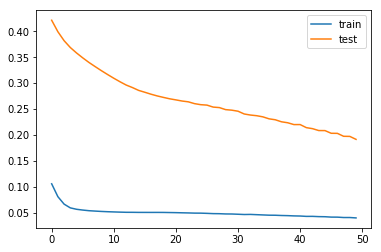

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Найдем прогноз и посчитаем среднеквадратичную ошибку

In [41]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 141.533


Графики предсказания и тестовой выборки

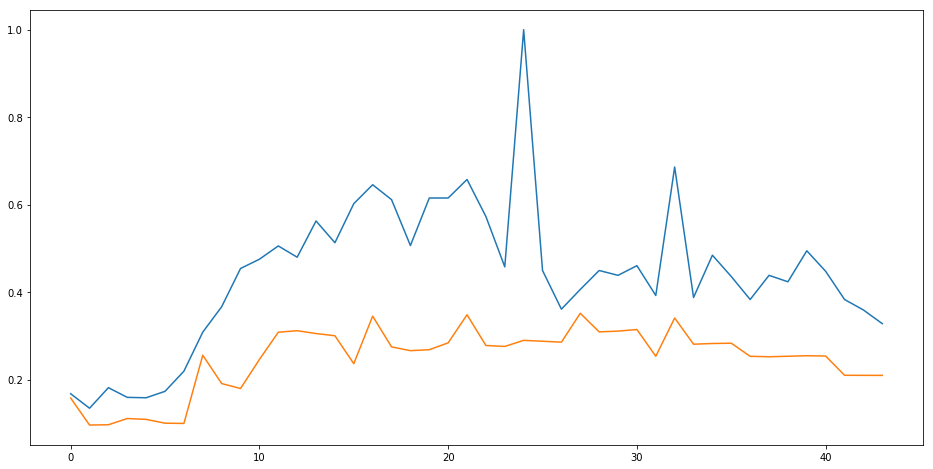

In [42]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()